**Unmount and Flush Google Drive**

This cell ensures a clean disconnection from Google Drive by flushing any pending data and securely unmounting the mounted directory. It's often run before a complete session restart or when switching Drive accounts.

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

# Mount Google Drive to the Notebook 💾

This cell is essential for **accessing files and data stored in your Google Drive** from within the Colab environment. Running this command will prompt you to authorize and connect your Drive account, mounting it to the path `/content/drive/`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install Ultralytics Library (YOLO Models)

This command installs the powerful `ultralytics` package, which is commonly used for working with state-of-the-art YOLO (You Only Look Once) models for object detection and image segmentation.

In [ ]:
!pip install ultralytics

# Initialize YOLOv8 Model for Object Detection

This block imports the **YOLO** class from the `ultralytics` library and loads the pre-trained **YOLOv8n** (Nano) model weights (`yolov8n.pt`). This model, named `model_det`, is now ready for tasks like detection, tracking, or inference.

In [ ]:
from ultralytics import YOLO

model_det = YOLO('yolov8n.pt')

# Perform Object Detection on a Single Image 🖼️

This block defines the **path to a specific input image** on Google Drive, then runs the pre-loaded **`model_det` (YOLOv8)** to perform object detection on that image. Finally, it displays the output, showing the image with bounding boxes around detected objects.


image 1/1 /content/drive/MyDrive/SAAID/DATASET/data/training_images/vid_4_9995.jpg: 544x640 1 car, 2 trucks, 79.9ms
Speed: 4.5ms preprocess, 79.9ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)


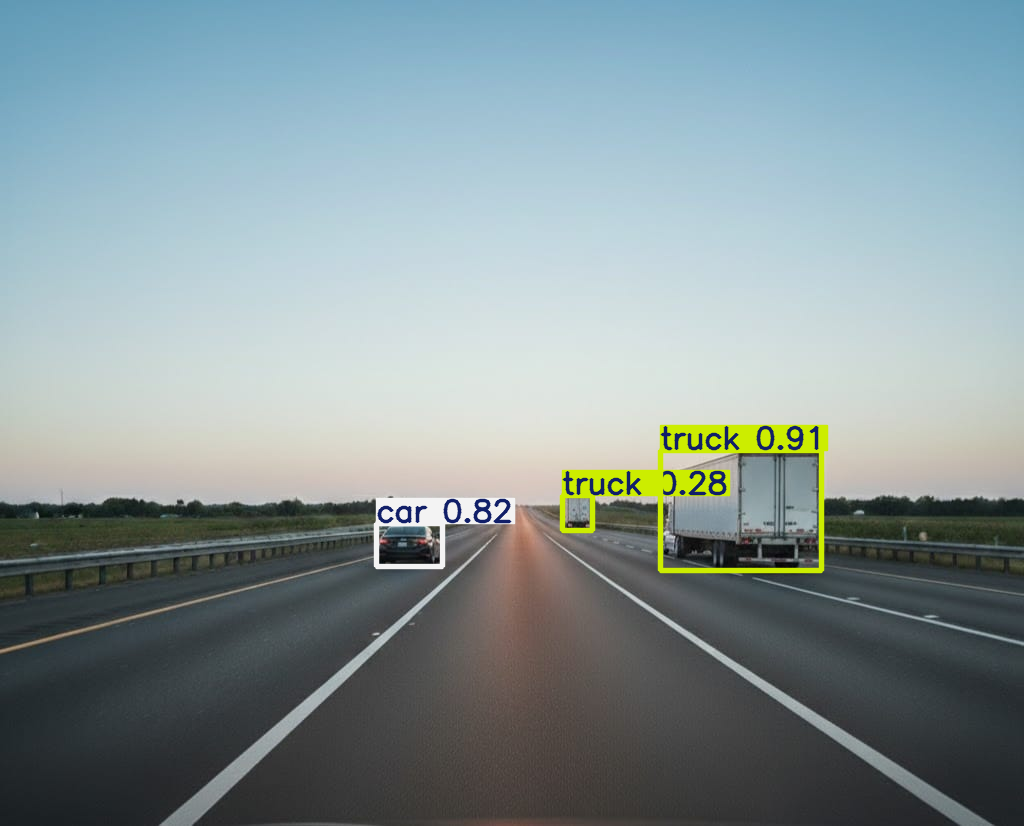

In [ ]:
path = '/content/drive/MyDrive/SAAID/DATASET/data/training_images/vid_4_9995.jpg'

results = model_det(path)
results[0].show()

# Install `timm` Library for Computer Vision Models

This command installs the **`timm` (PyTorch Image Models)** library. This library provides a massive collection of state-of-the-art pre-trained deep learning models for image recognition, which is essential for advanced computer vision tasks.

In [ ]:
!pip install timm

# Install OpenCV (Computer Vision Library) 📸

This command installs **OpenCV (`opencv-python`)**, which is the leading open-source library for computer vision, image processing, and video analysis. It's often required for tasks like loading images, manipulating pixels, and video streaming.

In [ ]:
!pip install opencv-python

# Import Core Libraries: PyTorch, OpenCV, and urllib 📦

This essential block imports the necessary libraries for the pipeline:
* **`torch`**: The **PyTorch** deep learning framework, crucial for model operations.
* **`cv2`**: The **OpenCV** library, used for image and video processing tasks.
* **`urllib.request`**: Used for fetching data or files directly from the web via URLs.

In [ ]:
import torch
import cv2
import urllib.request

# Set Device for Model Computation (GPU or CPU) ⚙️

This block dynamically checks for the availability of a **CUDA-enabled GPU** (which is common in Colab when a high-RAM/accelerated runtime is selected). If a GPU is found, it sets the `device` variable to **`cuda`** for faster processing; otherwise, it defaults to **`cpu`**. This ensures optimal performance for deep learning tasks.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and Initialize the MiDaS Depth Estimation Model 🧠

This crucial block performs the following steps:
1.  **Loads the MiDaS Model:** It uses `torch.hub.load` to fetch the pre-trained **MiDaS** model from the Intel-ISL repository, which is designed for robust **monocular depth estimation**.
2.  **Sets Device and Mode:** The model is moved to the defined `device` (GPU/CPU) and set to **evaluation mode** (`midas.eval()`) to optimize performance and freeze weights.
3.  **Loads Transformations:** It loads the necessary data transformations (`midas_transforms`) required to correctly preprocess input images before feeding them into the MiDaS model. The specific `transform` (DPT or small) is selected based on the loaded model version.

In [ ]:
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS")
midas.to(device)
midas.eval()


midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")


transform = midas_transforms.dpt_transform if "dpt" in "MiDaS" else midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading weights:  None


Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


# Load Input Image and Convert Color Format 🎨

This block prepares the source image for processing:
1.  **Sets Image Path:** Defines the `depth_image_path` variable to the location of the target image on Google Drive.
2.  **Loads Image:** Uses **OpenCV (`cv2.imread`)** to load the image into memory.
3.  **Converts Color Space:** Converts the image color format from **BGR** (the default in OpenCV) to **RGB**, which is the standard expected format for most PyTorch and computer vision models like MiDaS.

In [ ]:

depth_image_path = '/content/drive/MyDrive/SAAID/DATASET/data/training_images/vid_4_9995.jpg'


img = cv2.imread(depth_image_path)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Run MiDaS Model for Depth Prediction 🚀

This critical block executes the depth estimation process:

1.  **Preprocessing:** The loaded image (`img`) is preprocessed using the defined `transform` and moved to the designated `device` (GPU/CPU) to create the `input_batch`.
2.  **Inference:** The model is run within the `torch.no_grad()` context to save memory and skip gradient calculation, generating the raw `prediction`.
3.  **Post-processing:** The prediction is rescaled and resized using **Bicubic Interpolation** to match the original image dimensions (`img.shape[:2]`).
4.  **Final Output:** The resulting depth map is moved back to the CPU and converted into a **NumPy array** (`depth_map`) for visualization or further processing.

In [ ]:

input_batch = transform(img).to(device)


with torch.no_grad():
    prediction = midas(input_batch)


    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()


depth_map = prediction.cpu().numpy()

# Visualize Results: Original Image vs. Depth Map 📊

This block uses the **`matplotlib.pyplot`** library to display the results side-by-side for comparison:
1.  **Creates Subplots:** It sets up a figure with two subplots (`1` row, `2` columns).
2.  **Original Image:** The first subplot displays the preprocessed input image (`img`).
3.  **Depth Map:** The second subplot displays the generated depth array (`depth_map`) using a color map (like `'plasma'`), where varying colors represent estimated distances (depth).
4.  **Display:** Finally, `plt.show()` renders the visualization.

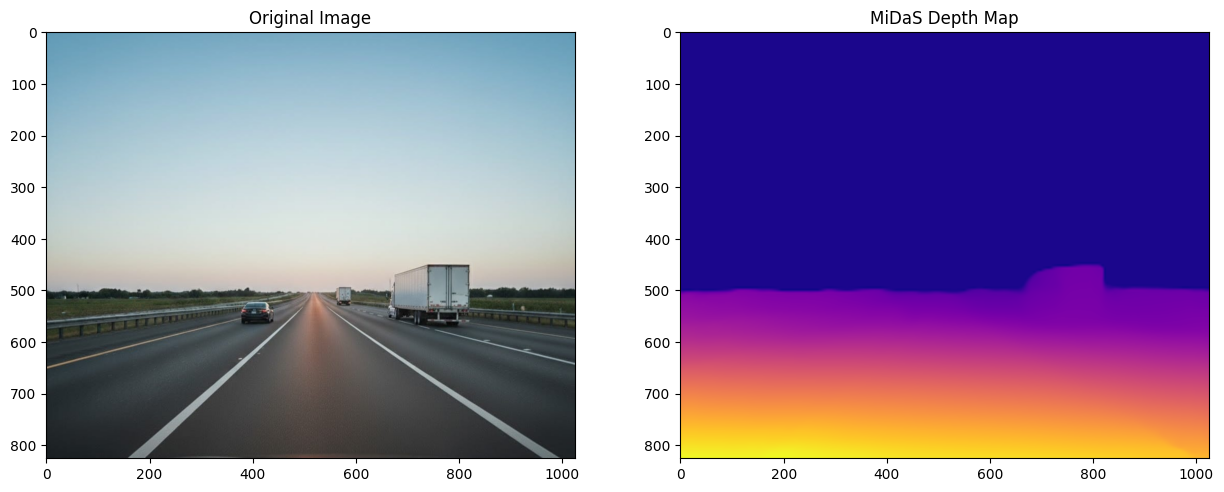

In [ ]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 2, figsize=(15, 15))


axes[0].imshow(img)
axes[0].set_title('Original Image')


axes[1].imshow(depth_map, cmap='plasma')
axes[1].set_title('MiDaS Depth Map')

plt.show()

# Canny Edge Detection and Visualization 🔎

This final block demonstrates a core image processing technique: **Edge Detection**.

1.  **Load and Grayscale:** The original image is loaded from Google Drive and converted to **grayscale**.
2.  **Blurring:** A **Gaussian Blur** is applied to reduce noise and help the edge detection process.
3.  **Canny Detection:** The **Canny Edge Detector** is applied, which accurately finds sharp intensity changes in the image.
4.  **Visualization:** The resulting binary edge map (`canny`) is displayed using Matplotlib, showing only the detected contours or boundaries.

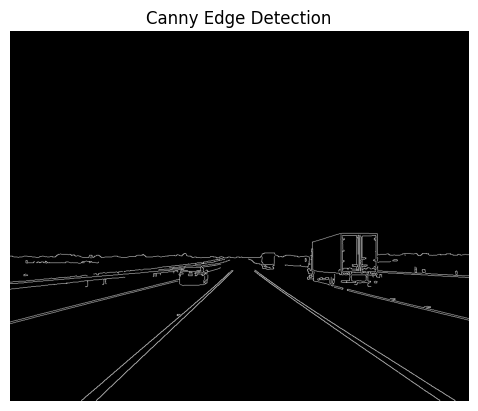

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


path = '/content/drive/MyDrive/SAAID/DATASET/data/training_images/vid_4_9995.jpg'
image = cv2.imread(path)


gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


blur = cv2.GaussianBlur(gray_image, (5, 5), 0)


canny = cv2.Canny(blur, 50, 150)


plt.imshow(canny, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')
plt.show()

# Lane Detection Pipeline (ROI and Hough Transform) 🛣️

This comprehensive block implements the main logic for detecting road lanes:

1.  **`region_of_interest` Function:** Defines a function to mask the image, focusing processing only on a specific area (a trapezoid defined by `region_vertices`)—typically the road ahead.
2.  **Apply ROI:** The function is applied to the Canny edge map (`canny`) to create `isolated_canny`.
3.  **Hough Line Detection:** The **Probabilistic Hough Transform (`cv2.HoughLinesP`)** is used on the isolated edges to mathematically identify and extract line segments.
4.  **Visualization:**
    * The detected lines are drawn onto a blank `line_image`.
    * The line image is overlaid onto the original image using `cv2.addWeighted` for a transparent effect.
    * The final result, showing the detected lanes on the road, is displayed.

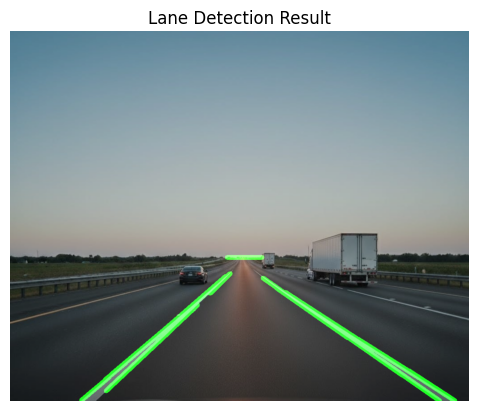

In [ ]:

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


height, width = canny.shape
region_vertices = [
    (0, height),
    (width / 2, height / 2 + 50),
    (width, height)
]

isolated_canny = region_of_interest(canny, np.array([region_vertices], np.int32))


lines = cv2.HoughLinesP(isolated_canny, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)


line_image = np.zeros_like(image)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 10)


final_image = cv2.addWeighted(image, 0.8, line_image, 1, 1)

plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
plt.title('Lane Detection Result')
plt.axis('off')
plt.show()

# Integrated YOLO & MiDaS: Object Detection with Relative Depth Calculation 💡

This comprehensive block combines the previously loaded models to perform real-time depth-aware detection:

1.  **Libraries & Image Load:** Imports necessary libraries (CV2, NumPy, PyTorch) and loads the target image from Drive, performing the BGR-to-RGB conversion and an error check.
2.  **MiDaS Depth Estimation:** Runs the **MiDaS model** on the image to generate a precise `depth_map`.
3.  **YOLO Detection:** Runs the **YOLOv8 model (`model_det`)** to detect objects and extract their bounding box coordinates (`boxes`) and classes (`classes`).
4.  **Depth Calculation:** It iterates through each detected object:
    * It uses the bounding box to **crop the corresponding area** from the `depth_map`.
    * It calculates the **median depth** of that area.
5.  **Output:** Prints the object's class name, coordinates, and its calculated **Relative Depth** (distance). This is crucial for applications like autonomous driving and robot navigation.

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt


path = '/content/drive/MyDrive/SAAID/DATASET/data/training_images/vid_4_9995.jpg'


frame = cv2.imread(path)
if frame is None:
    raise FileNotFoundError(f"Error: Image file not found at {path}")
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)



input_batch = transform(frame_rgb).to(device)
with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=frame_rgb.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
depth_map = prediction.cpu().numpy()



results_yolo = model_det(frame_rgb, verbose=False)

boxes = results_yolo[0].boxes.xyxy.cpu().numpy()
classes = results_yolo[0].boxes.cls.cpu().numpy()

names = results_yolo[0].names

for box, cls in zip(boxes, classes):

    class_name = names[int(cls)]

    x_min, y_min, x_max, y_max = [int(val) for val in box]

    if y_max <= depth_map.shape[0] and x_max <= depth_map.shape[1] and y_min >= 0 and x_min >= 0:

        detected_object_depth = depth_map[y_min:y_max, x_min:x_max]
        median_distance = np.median(detected_object_depth)

        print(f"Object: {class_name} at ({x_min},{y_min}): Relative Depth = {median_distance:.2f}")

Object: truck at (660,450): Relative Depth = 486.29
Object: car at (376,522): Relative Depth = 580.90


# Full Video Processing Pipeline: YOLO, MiDaS & Lane Detection Fusion 🎥

This massive block executes the entire project workflow on a video stream, reading the input video from Google Drive, processing each frame, and writing the final integrated result to a new video file.

---

## Core Steps Per Frame:

1.  **Video Setup:** Initializes video capture (`cv2.VideoCapture`) and video writer (`cv2.VideoWriter`) with correct dimensions and FPS.
2.  **Model Checks:** Ensures that both **YOLO (`model_det`)** and **MiDaS** are successfully loaded before starting the loop.
3.  **Frame Processing Loop:** Reads frames one by one (`cap.read()`):
    * **Object Detection (YOLO):** Runs YOLO to detect objects and plot bounding boxes onto the frame.
    * **Depth Estimation (MiDaS):** Runs MiDaS on the frame to generate the **depth map**.
    * **Fusion & Annotation:** Calculates the **median relative depth** for each detected object's bounding box and annotates the frame with the object's class and distance.
    * **Lane Detection:** Applies **Canny Edge Detection**, **Region of Interest (ROI) masking**, and the **Hough Transform** to detect road lanes.
    * **Final Integration:** The lane lines are overlaid onto the object detection frame using `cv2.addWeighted`.
4.  **Output & Cleanup:** The final integrated frame is written to the output video (`out.write()`). After the loop finishes, all video resources are safely released.

In [ ]:
import cv2
import numpy as np
import torch
import os


def region_of_interest(img, vertices):

    mask = np.zeros_like(img)
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


input_video_path = '/content/drive/MyDrive/SAAID/DATASET/data/training_images/vid_5_1.mp4'
output_video_path = '/content/drive/MyDrive/SAAID/DATASET/data/car_driver1.mp4'


if 'model_det' not in locals() or 'midas' not in locals():
    print("Error: YOLO or MiDaS models not loaded. Please run the setup cells first.")
    raise NameError("Model variables are missing.")

names = model_det.names
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    raise IOError(f"Video file not found or path is incorrect: {input_video_path}")

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

print(f"Starting full fusion processing at {fps} FPS...")


frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1


    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results_yolo = model_det(frame_rgb, verbose=False)
    output_frame_bgr = results_yolo[0].plot()


    input_batch = transform(frame_rgb).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=frame_rgb.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    depth_map = prediction.cpu().numpy()


    boxes = results_yolo[0].boxes.xyxy.cpu().numpy()
    clss = results_yolo[0].boxes.cls.cpu().numpy()

    for box, cls in zip(boxes, clss):
        x_min, y_min, x_max, y_max = [int(val) for val in box]

        if y_max <= depth_map.shape[0] and x_max <= depth_map.shape[1] and y_min >= 0 and x_min >= 0:
            detected_object_depth_area = depth_map[y_min:y_max, x_min:x_max]
            median_distance = np.median(detected_object_depth_area)
            class_name = names[int(cls)]
            distance_text = f"{class_name}: D={median_distance:.2f}"


            cv2.putText(
                output_frame_bgr,
                distance_text,
                (x_min, y_min - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6, (0, 0, 255), 2, cv2.LINE_AA
            )


    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray_frame, (5, 5), 0)
    canny = cv2.Canny(blur, 50, 150)


    region_vertices = [
        (int(frame_width * 0.05), frame_height),
        (int(frame_width * 0.40), int(frame_height * 0.65)),
        (int(frame_width * 0.60), int(frame_height * 0.65)),
        (int(frame_width * 0.95), frame_height)
    ]
    isolated_canny = region_of_interest(canny, np.array([region_vertices], np.int32))


    lines = cv2.HoughLinesP(isolated_canny, rho=2, theta=np.pi/180, threshold=50,
                            lines=np.array([]), minLineLength=10, maxLineGap=20)


    lane_line_image = np.zeros_like(output_frame_bgr)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cv2.line(lane_line_image, (x1, y1), (x2, y2), (0, 255, 0), 8)


    final_integrated_frame = cv2.addWeighted(output_frame_bgr, 1, lane_line_image, 1, 0)


    out.write(final_integrated_frame)

    if frame_count % 100 == 0:
        print(f"Frames processed: {frame_count}")



print("Releasing video resources...")
cap.release()
out.release()
print("=========================================================")
print(f"SUCCESS: Full fusion video saved as 'car_driver1.mp4' at: {output_video_path}")
print("=========================================================")

Starting full fusion processing at 29 FPS...
Frames processed: 100
Frames processed: 200
Frames processed: 300
Frames processed: 400
Frames processed: 500
Frames processed: 600
Frames processed: 700
Frames processed: 800
Frames processed: 900
Frames processed: 1000
Frames processed: 1100
Releasing video resources...
SUCCESS: Full fusion video saved as 'car_driver1.mp4' at: /content/drive/MyDrive/SAAID/DATASET/data/car_driver1.mp4


# Install gTTS (Google Text-to-Speech) Library 🗣️

This command installs the **`gTTS` (Google Text-to-Speech)** library. This lightweight and easy-to-use library is essential for converting text strings into audible speech in an MP3 format, allowing the notebook to generate sound feedback or audio output.

In [ ]:
!pip install gTTS

# Final ADAS System: Video Processing with Voice Alerts (English) 🚨🗣️

This is the **final, fully integrated pipeline** combining all models and functionalities (YOLO, MiDaS, Lane Detection) and adding a critical safety layer: **real-time voice guidance**.

---

## Key Added Features:

1.  **Voice Feedback Function:** The **`speak_and_wait`** function is defined using `gTTS` and `IPython.display` to convert text commands into spoken English audio warnings and manage playback timing.
2.  **Proximity Alert Logic:** A **`DANGER_THRESHOLD`** is set (1000 in the depth map). The code checks the median depth of critical objects (`car`, `truck`, `bus`, `person`).
3.  **Voice Command:** If an object is closer than the threshold:
    * It issues a general warning ("Attention, [class name] ahead.").
    * For extremely close objects (e.g., `< 100`), it issues a **"Critical alert! Brake immediately."** command.
4.  **Frequency Control:** The `already_warned_this_second` flag prevents rapid, distracting warnings by limiting alerts to roughly one per second (controlled by `fps * 4`).
5.  **Output:** The final video, complete with visual bounding boxes, distance annotations, and lane lines, is saved to the specified output path.

In [ ]:
import cv2
import numpy as np
import torch
import os
import time



from gtts import gTTS
from IPython.display import Audio, display, clear_output


def speak_and_wait(text, filename="temp_audio.mp3", lang='en'):

    try:
        tts = gTTS(text=text, lang=lang, slow=False)
        tts.save(filename)


        display(Audio(filename, autoplay=True))


        wait_time = len(text.split()) * 0.4
        time.sleep(wait_time)
        clear_output(wait=True)

    except Exception as e:

        pass


def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


input_video_path = '/content/drive/MyDrive/SAAID/DATASET/data/training_images/vid_5_1.mp4'
output_video_path = '/content/drive/MyDrive/SAAID/DATASET/data/car_driver_final_en.mp4'


DANGER_THRESHOLD = 1000


names = model_det.names
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    raise IOError(f"Video file not found or path is incorrect: {input_video_path}")

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

print(f"Starting final processing with English voice guidance at {fps} FPS...")


frame_count = 0
already_warned_this_second = False

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1


    if frame_count % max(1, fps * 4) == 1:
        already_warned_this_second = False



    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


    results_yolo = model_det(frame_rgb, verbose=False)
    output_frame_bgr = results_yolo[0].plot()


    input_batch = transform(frame_rgb).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=frame_rgb.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    depth_map = prediction.cpu().numpy()


    boxes = results_yolo[0].boxes.xyxy.cpu().numpy()
    clss = results_yolo[0].boxes.cls.cpu().numpy()

    for box, cls in zip(boxes, clss):
        x_min, y_min, x_max, y_max = [int(val) for val in box]

        if y_max <= depth_map.shape[0] and x_max <= depth_map.shape[1] and y_min >= 0 and x_min >= 0:
            detected_object_depth_area = depth_map[y_min:y_max, x_min:x_max]
            median_distance = np.median(detected_object_depth_area)
            class_name = names[int(cls)]
            distance_text = f"{class_name}: Dist={median_distance:.2f}"


            if median_distance < DANGER_THRESHOLD and not already_warned_this_second:
                if class_name in ['car', 'truck', 'bus', 'person']:
                    if median_distance < 100:
                        command = f"Critical alert! {class_name} too close. Brake immediately."
                    else:
                        command = f"Attention, {class_name} ahead."

                    print(f"Voice Command: {command}")
                    speak_and_wait(command, lang='en')
                    already_warned_this_second = True


            cv2.putText(
                output_frame_bgr,
                distance_text,
                (x_min, y_min - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6, (0, 0, 255), 2, cv2.LINE_AA
            )


    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray_frame, (5, 5), 0)
    canny = cv2.Canny(blur, 50, 150)

    region_vertices = [
        (int(frame_width * 0.05), frame_height),
        (int(frame_width * 0.40), int(frame_height * 0.65)),
        (int(frame_width * 0.60), int(frame_height * 0.65)),
        (int(frame_width * 0.95), frame_height)
    ]
    isolated_canny = region_of_interest(canny, np.array([region_vertices], np.int32))

    lines = cv2.HoughLinesP(isolated_canny, rho=2, theta=np.pi/180, threshold=50,
                            lines=np.array([]), minLineLength=10, maxLineGap=20)

    lane_line_image = np.zeros_like(output_frame_bgr)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cv2.line(lane_line_image, (x1, y1), (x2, y2), (0, 255, 0), 8) # خط أخضر


    final_integrated_frame = cv2.addWeighted(output_frame_bgr, 1, lane_line_image, 1, 0)
    out.write(final_integrated_frame)

    if frame_count % 100 == 0:
        print(f"Frames processed: {frame_count}")



print("Releasing video resources...")
cap.release()
out.release()
print("=========================================================")
print(f"SUCCESS: Full fusion video saved as 'car_driver_final_en.mp4' at: {output_video_path}")
print("=========================================================")

Releasing video resources...
SUCCESS: Full fusion video saved as 'car_driver_final_en.mp4' at: /content/drive/MyDrive/SAAID/DATASET/data/car_driver_final_en.mp4


# ADAS Decision Core Simulation with Voice Guidance 🧠🗣️

This block initializes the **core logic** for a sophisticated Advanced Driver Assistance System (ADAS). Instead of processing a full video, it **simulates** the two main components: the AI decision-making module and the sensor data analysis.

---

## Key Components:

1.  **`speak_command` Function:** A refined utility for **Text-to-Speech (TTS)** using `gTTS` to provide immediate, spoken feedback to the user, simulating a cockpit warning system.
2.  **`AI_Driving_Model` Class:** This class simulates the deep learning model's core intelligence, capable of running in two distinct modes:
    * **"Instructor" Mode:** Provides **precision-focused feedback** based on simulated lane deviation (e.g., precise steering instructions).
    * **"Co-Pilot" Mode:** Provides **safety-focused, proactive alerts** based on simulated obstacle distance and weather conditions (e.g., emergency braking warnings).
3.  **`analyze_frame` Function:** Simulates the **sensor fusion process** (like the output of YOLO and MiDaS), generating random values for **lane deviation** and **obstacle distance** for the AI model to act upon.

This setup allows for rapid testing and refinement of the AI's complex decision-making logic before deployment to a real-time environment.

In [ ]:
import cv2
import numpy as np
import torch
import time
from gtts import gTTS
from IPython.display import Audio, display, clear_output
import random

# --- Voice Guidance Function ---
def speak_command(text):
    """ Converts text to speech and plays it. """
    try:
        tts = gTTS(text=text, lang='en', slow=False)
        tts.save("command_audio.mp3")
        display(Audio("command_audio.mp3", autoplay=True))
        time.sleep(len(text.split()) * 0.3)
        clear_output(wait=True)
    except Exception as e:
        pass

# --- AI Core: Deep Learning Model Simulation (PyTorch/TensorFlow) ---
class AI_Driving_Model:
    def __init__(self, mode="Instructor"):
        self.mode = mode
        print(f"\nAI System Initialized in {mode} Mode.")

    # This function is the system's core: it accepts sensor data and issues a decision.
    def make_decision(self, lane_deviation, obstacle_distance, weather_ok=True):
        if self.mode == "Instructor":
            return self._instructor_logic(lane_deviation)
        elif self.mode == "Co-Pilot":
            return self._copilot_logic(obstacle_distance, weather_ok)
        return "System standby."

    def _instructor_logic(self, deviation):
        """ Instructor Logic: Educational and precise (Focuses on performance) """
        if deviation > 50:
            return "Critical: Hard brake immediately, you missed the marker!"
        elif deviation > 15:
            return "Steer gently to the right. Maintain precision."
        elif deviation < -15:
            return "Steer gently to the left. Maintain precision."
        else:
            return "Perfect line. Maintain speed and focus."

    def _copilot_logic(self, distance, weather_ok):
        """ Co-Pilot Logic: Proactive and preventive (Focuses on safety) """
        if not weather_ok:
            return "Warning: Visibility is low! Reduce speed and increase following distance."

        if distance < 50: # Critical distance (less than approx. 2 meters)
            # In the actual system, ROS would activate autonomous braking here.
            return "EMERGENCY! Autonomous braking activated. Danger too close!"
        elif distance < 100: # Close distance (approx. 3-4 meters)
            return "Safety Alert: Immediate hazard ahead! Prepare to brake."
        else:
            return "Driving conditions normal. Observe surrounding traffic."

# --- Computer Vision Simulation (OpenCV/LiDAR) ---
def analyze_frame(frame):
    """ (OpenCV/LiDAR Fusion Simulation) """
    # In a real application, this would involve YOLO and MiDaS for processing.

    # Simulation of image analysis results:
    lane_deviation = np.random.randint(-20, 20) # Deviation from lane center
    obstacle_distance = np.random.randint(50, 250) # Distance to nearest object (in meters or relative depth units)

    return lane_deviation, obstacle_distance

# ADAS Simulation Execution: Testing Instructor and Co-Pilot Modes 🧪

This final block runs a sequential demonstration of the `AI_Driving_Model`'s decision-making logic using predefined test scenarios for both operational modes. This serves as a functional test to verify that the AI's complex logic is issuing the correct voice commands based on simulated sensor inputs (deviation and distance).

---

## 1. Instructor Role Simulation

* **Mode:** Set to `"Instructor"`. Focuses on **precision and performance** (simulating a race track or driving test scenario).
* **Test Cases:** The code iterates through various `lane_deviation` values (`10`, `30`, `-5`).
* **Output:** Generates precise, corrective voice commands (e.g., "Steer gently to the right," "Hard brake immediately").

---

## 2. Co-Pilot Role Simulation

* **Mode:** Switches to `"Co-Pilot"`. Focuses on **safety and prevention** (simulating public road driving).
* **Test Cases:** Iterates through various `obstacle_distance` values (`200`, `80`, `40`), including a simulated **bad weather** scenario in the second cycle.
* **Output:** Generates proactive voice alerts based on proximity and safety factors (e.g., "Safety Alert," "EMERGENCY! Autonomous braking activated").

The final output demonstrates the system's ability to **contextually adapt its advice and warnings** based on the selected operational mode and the severity of the simulated driving conditions.

In [ ]:
# ----------------------------------------------------
# 1. Track Scenario (Instructor Role)
# ----------------------------------------------------
ai_system = AI_Driving_Model(mode="Instructor")

# Track testing scenarios
test_deviations = [10, 30, -5] # Minor deviation, large deviation, perfect deviation

for i, dev in enumerate(test_deviations):
    print(f"\n--- INSTRUCTOR CYCLE {i+1} --- (Deviation: {dev} units)")

    # Image analysis simulation
    lane_deviation, _ = analyze_frame(None) # Distance is ignored here

    # Educational decision-making
    command = ai_system.make_decision(dev, 0)

    print(f"COMMAND: {command}")
    speak_command(command)
    time.sleep(1)


# ----------------------------------------------------
# 2. Transition to Co-Pilot Role
# ----------------------------------------------------
ai_system.mode = "Co-Pilot"
print("\n" + "="*50)
print("SYSTEM MODE SWITCHED TO: Co-Pilot (Public Road Safety)")
print("="*50)

# Public road testing scenarios
test_distances = [200, 80, 40] # Safe distance, close distance, critical distance

for i, dist in enumerate(test_distances):
    print(f"\n--- CO-PILOT CYCLE {i+1} --- (Obstacle Distance: {dist} cm/units)")

    # Image and depth analysis simulation
    _, obstacle_distance = analyze_frame(None) # Deviation is ignored here

    # Preventive decision-making
    # Simulate bad weather in the second cycle
    weather_status = (i != 1)
    command = ai_system.make_decision(0, dist, weather_ok=weather_status)

    print(f"ALERT: {command}")
    speak_command(command)
    time.sleep(1)

print("\n--- End of Simulation ---")


--- End of Simulation ---
